<a href="https://colab.research.google.com/github/RyanHansK/Image-Captioning--CLIP-GPT---VilBERT/blob/main/Clip%2BGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # @title Install torch and other libraries
!pip install torch
!pip install transformers
!pip install streamlit
# !pip install fiftyone
!pip install tqdm
!pip install Pillow
!pip install git+https://github.com/openai/CLIP.git
!pip install wandb
!pip install gradio
!pip install git+https://github.com/salaniz/pycocoevalcap.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lvs6c7l_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lvs6c7l_
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=226379682ed91e210a4b67f2eb84decca8e9a96d3e94e4faaebf359c988ac9a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ify0a9ey/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Succe

In [2]:
# @title Download dataset

import os
import requests
from zipfile import ZipFile
from pycocotools.coco import COCO
from tqdm import tqdm
from PIL import Image
from io import BytesIO
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Google drive path
COCO_DIR = '/content/drive/MyDrive/COCO_subset'
# Test path
test_zip_path = os.path.join(COCO_DIR, 'images', "test2017.zip")
os.makedirs(COCO_DIR, exist_ok=True)

# COCO annotations URL
COCO_ANNOTATIONS_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
TRAIN_IMAGES_URL = "http://images.cocodataset.org/zips/train2017.zip"
VAL_IMAGES_URL = "http://images.cocodataset.org/zips/val2017.zip"
TEST_IMAGES_URL = "http://images.cocodataset.org/zips/test2017.zip"
images_dir = os.path.join(COCO_DIR, 'images')
test_images_dir = os.path.join(COCO_DIR, 'images', 'test2017')

# Download and extract annotations to Google Drive
def download_coco_annotations():
    print("Checking if annotations are already downloaded...")
    annotations_zip_path = os.path.join(COCO_DIR, "annotations_trainval2017.zip")
    annotations_extract_dir = os.path.join(COCO_DIR, "annotations")

    if not os.path.exists(os.path.join(annotations_extract_dir, 'captions_train2017.json')):
        if not os.path.exists(annotations_zip_path):
            # Download annotations if they don't exist
            print("Downloading COCO annotations...")
            response = requests.get(COCO_ANNOTATIONS_URL, stream=True)
            with open(annotations_zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

        # Extract the annotations zip
        print("Extracting COCO annotations...")
        with ZipFile(annotations_zip_path, 'r') as zip_ref:
            zip_ref.extractall(annotations_extract_dir)
        print("Annotations downloaded and extracted.")
    else:
        print("Annotations already exist. Skipping download.")

# Download and extract trainval images
def download_and_extract_images(images_url, save_dir, dataset_name):
    zip_path = os.path.join(COCO_DIR, f'{dataset_name}.zip')

    if not os.path.exists(save_dir):
        if not os.path.exists(zip_path):
            print(f"Downloading {dataset_name} images...")
            response = requests.get(images_url, stream=True)
            with open(zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

        # Extract the images
        print(f"Extracting {dataset_name} images...")
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(save_dir)
        print(f"{dataset_name} images downloaded and extracted.")
    else:
        print(f"{dataset_name} images already exist. Skipping download.")

# Download a subset of COCO images (for training and validation datasets)
def download_coco_images(coco, save_dir, num_images=8000):
    if not os.path.exists(save_dir):
        # Get all image IDs
        all_image_ids = coco.getImgIds()

        # Select a random subset of image IDs
        import random
        subset_image_ids = random.sample(all_image_ids, num_images)
        print(f"Selected {len(subset_image_ids)} images for the subset.")

        # Directory to save images
        os.makedirs(save_dir, exist_ok=True)

        # Download each image in the subset
        for img_id in tqdm(subset_image_ids):
            img_info = coco.loadImgs(img_id)[0]
            download_image(img_info, save_dir)
        print(f"Downloaded {len(subset_image_ids)} images to {save_dir}.")
    else:
      print(f"{save_dir} already exists. Skipping download.")

# Download images
def download_image(img_info, save_dir):
    img_url = img_info['coco_url']
    img_filename = os.path.join(save_dir, img_info['file_name'])

    # Download the image only if it doesn't exist
    if not os.path.exists(img_filename):
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content))
        img.save(img_filename)

# Download the test dataset
def download_test_dataset(zip_path, images_url):
    if not os.path.exists(zip_path):
        print(f"Downloading COCO 2017 test dataset...")
        response = requests.get(images_url, stream=True)
        with open(zip_path, 'wb') as f:
            for chunk in tqdm(response.iter_content(chunk_size=8192)):
                f.write(chunk)
        print(f"Test dataset downloaded to {zip_path}")
    else:
        print(f"Test dataset already exists at {zip_path}. Skipping download.")

# Extract a subset of test images
def extract_test_subset(zip_path, extract_dir, num_files=100):
    # Open the zip file
    if not os.path.exists(zip_path):
        with ZipFile(zip_path, 'r') as zip_ref:
            # List all the files in the zip
            all_files = zip_ref.namelist()

            # Filter the JPG images
            image_files = [f for f in all_files if f.endswith('.jpg')]

            # Extract only the first `num_files` images
            for img_file in image_files[:num_files]:
                zip_ref.extract(img_file, extract_dir)
                print(f"Extracted {img_file}")

            print(f"Extracted {num_files} images to {extract_dir}")
    else:
        print(f"Test dataset zip file already exists at {zip_path}. Skipping extraction.")


# Run the process
download_coco_annotations()

# Directories for training, validation, and test images
train_images_dir = os.path.join(COCO_DIR, 'images', 'train2017')
val_images_dir = os.path.join(COCO_DIR, 'images', 'val2017')
test_images_dir = os.path.join(COCO_DIR, 'images', 'test2017')

# Download and extract training and validation images
download_and_extract_images(TRAIN_IMAGES_URL, train_images_dir, "train2017")
download_and_extract_images(VAL_IMAGES_URL, val_images_dir, "val2017")

# Get a subset of training and validation images
train_coco = COCO(os.path.join(COCO_DIR, "annotations/annotations", "captions_train2017.json"))
download_coco_images(train_coco, train_images_dir, num_images=1000)

val_coco = COCO(os.path.join(COCO_DIR, "annotations/annotations", "captions_val2017.json"))
download_coco_images(val_coco, val_images_dir, num_images=100)

# Download the test dataset if it doesn't exist
download_test_dataset(test_zip_path, TEST_IMAGES_URL)
# Download a subset of test images
extract_test_subset(test_zip_path, test_images_dir, num_files=100)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checking if annotations are already downloaded...
Extracting COCO annotations...
Annotations downloaded and extracted.
train2017 images already exist. Skipping download.
val2017 images already exist. Skipping download.
loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
/content/drive/MyDrive/COCO_subset/images/train2017 already exists. Skipping download.
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
/content/drive/MyDrive/COCO_subset/images/val2017 already exists. Skipping download.
Test dataset already exists at /content/drive/MyDrive/COCO_subset/images/test2017.zip. Skipping download.
Test dataset zip file already exists at /content/drive/MyDrive/COCO_subset/images/test2017.zip. Skipping extraction.


In [3]:
# @title Dataloader
#------------------------------------------ Imports---------------------------------------------
import torch
from torch.nn.utils.rnn import pad_sequence
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, CLIPProcessor, CLIPModel
from PIL import Image
from pycocotools.coco import COCO
import os
import gradio as gr
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# File paths
IMAGES_DIR = os.path.join(COCO_DIR, 'images')
TRAIN_ANNOTATIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'captions_train2017.json')
DETECTIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'instances_train2017.json')
VAL_ANNOTATIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'captions_val2017.json')

# File paths
TRAIN_IMAGES_DIR = os.path.join(COCO_DIR, 'images', 'train2017')
VAL_IMAGES_DIR = os.path.join(COCO_DIR, 'images', 'val2017')

# Ensure each dataset loads from its respective directory
def load_coco_annotations():
    coco_train_captions = COCO(TRAIN_ANNOTATIONS_FILE)
    coco_val_captions = COCO(VAL_ANNOTATIONS_FILE)
    coco_detections = COCO(DETECTIONS_FILE)
    print('exiting loading annotations')
    return coco_train_captions, coco_val_captions, coco_detections

coco_train_captions, coco_val_captions, coco_detections = load_coco_annotations()

# Get list of downloaded image file names
def get_downloaded_image_ids(images_dir):
    print('getting image ids')
    return {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')}

# Limit the number of images in train and validation
train_image_ids = get_downloaded_image_ids(TRAIN_IMAGES_DIR)
val_image_ids = get_downloaded_image_ids(VAL_IMAGES_DIR)

# Randomly sample 1000 train images and 100 val images
train_image_ids = random.sample(train_image_ids, min(1000, len(train_image_ids)))
val_image_ids = random.sample(val_image_ids, min(100, len(val_image_ids)))

# Dataset class with filtering for available images
class COCODataset(Dataset):
    def __init__(self, coco_captions, coco_detections, images_dir, clip_processor, gpt_tokenizer, available_image_ids,
                 max_length=50):
        print(f"Initializing COCODataset with {len(available_image_ids)} available images")
        self.coco_captions = coco_captions
        self.coco_detections = coco_detections
        self.images_dir = images_dir
        self.clip_processor = clip_processor
        self.gpt_tokenizer = gpt_tokenizer

        # Filter the image IDs to only include those that exist locally
        self.image_ids = [img_id for img_id in coco_captions.getImgIds()
                          if str(img_id).zfill(12) in available_image_ids]

        self.max_length = max_length
        print(f"Filtered dataset to {len(self.image_ids)} images")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco_captions.loadImgs(img_id)[0]
        img_filename = os.path.join(self.images_dir, img_info['file_name'])

        # Load image
        try:
            image = Image.open(img_filename).convert("RGB")

            # Get caption
            ann_ids = self.coco_captions.getAnnIds(imgIds=img_id)
            anns = self.coco_captions.loadAnns(ann_ids)
            caption = anns[0]['caption'] if anns else ""

            # Get object detection annotations
            object_ann_ids = self.coco_detections.getAnnIds(imgIds=img_id, iscrowd=False)
            object_anns = self.coco_detections.loadAnns(object_ann_ids)
            objects = [self.coco_detections.loadCats(obj['category_id'])[0]['name'] for obj in object_anns]

            # Preprocess the image using CLIPProcessor
            image_inputs = self.clip_processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)

            # Preprocess the caption using GPT2Tokenizer
            input_ids = self.gpt_tokenizer(caption, padding="max_length", truncation=True, max_length=self.max_length,
                                           return_tensors="pt")['input_ids'].squeeze(0)

            labels = input_ids.clone()  # Labels are identical to input_ids

            return image_inputs, input_ids, labels, objects

        except Exception as e:
            print(f"Error processing {img_filename}: {e}")
            return None, None, None, None


# collate function to filter out any None items
def collate_fn(batch):
    # Filter out any None items
    batch = [b for b in batch if b[0] is not None]
    if len(batch) == 0:
        return None, None, None, None
    initial_len = len(batch)
    batch = [b for b in batch if b[0] is not None]
    if len(batch) != initial_len:
        print(f"Filtered out {initial_len - len(batch)} samples.")

    images, captions, labels, objects = zip(*batch)

    # Stack the images and pad the captions/labels
    images = torch.stack(images)
    captions = pad_sequence(captions, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)

    return images, captions, labels, objects  # Return objects for optional visualization

# Initialize models and tokenizer
def initialize_models():
    # Load pre-trained CLIP model and processor
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Load pre-trained GPT-2 model and tokenizer
    gpt_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Set the padding token for GPT-2 tokenizer
    tokenizer.pad_token_id = tokenizer.eos_token_id

    return clip_model, clip_processor, gpt_model, tokenizer

# Initialize the models and tokenizer
clip_model, clip_processor, gpt_model, tokenizer = initialize_models()

# DataLoader initialization for training and validation datasets
def initialize_data_loaders():
    train_dataset = COCODataset(coco_train_captions, coco_detections, TRAIN_IMAGES_DIR, clip_processor, tokenizer,
                                train_image_ids)
    val_dataset = COCODataset(coco_val_captions, coco_detections, VAL_IMAGES_DIR, clip_processor, tokenizer,
                              val_image_ids)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
    return train_loader, val_loader

train_loader, val_loader = initialize_data_loaders()

# Print dataset sizes
print(f"Length of training dataset: {len(train_loader.dataset)}")
print(f"Length of validation dataset: {len(val_loader.dataset)}")


loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=16.40s)
creating index...
index created!
exiting loading annotations
getting image ids
getting image ids


<ipython-input-3-02592e6144c6>:49: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_image_ids = random.sample(train_image_ids, min(1000, len(train_image_ids)))
<ipython-input-3-02592e6144c6>:50: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_image_ids = random.sample(val_image_ids, min(100, len(val_image_ids)))
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Initializing COCODataset with 1000 available images
Filtered dataset to 1000 images
Initializing COCODataset with 100 available images
Filtered dataset to 100 images
Length of training dataset: 1000
Length of validation dataset: 100


Number of captions: 1000
Average caption length: 12.13 words


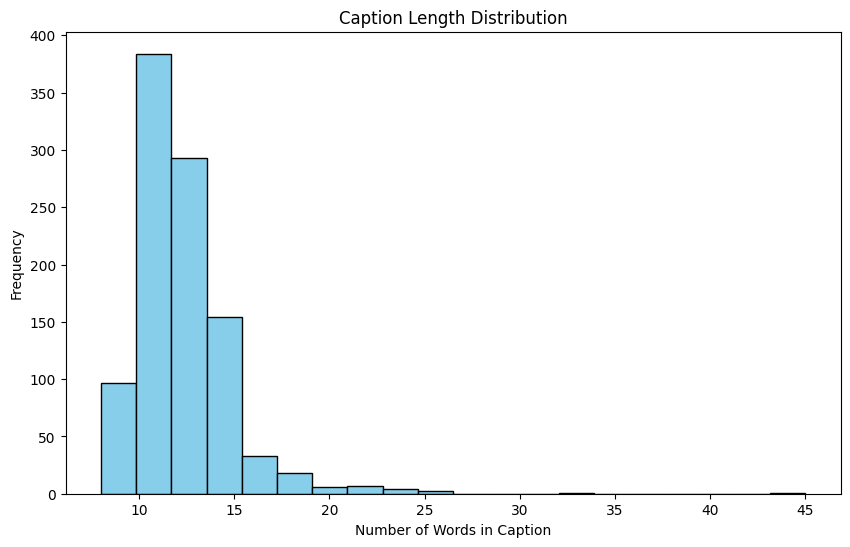


Total unique words: 1853
Most common words: [('a', 1750), ('of', 395), ('on', 386), ('the', 288), ('in', 272), ('with', 265), ('and', 232), ('man', 148), ('to', 127), ('sitting', 122)]


<ipython-input-31-d283a8e90a68>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


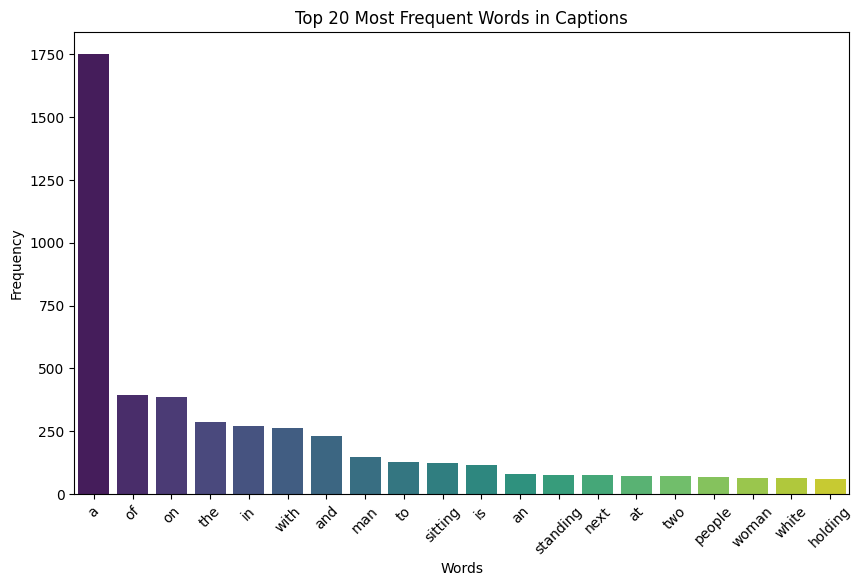

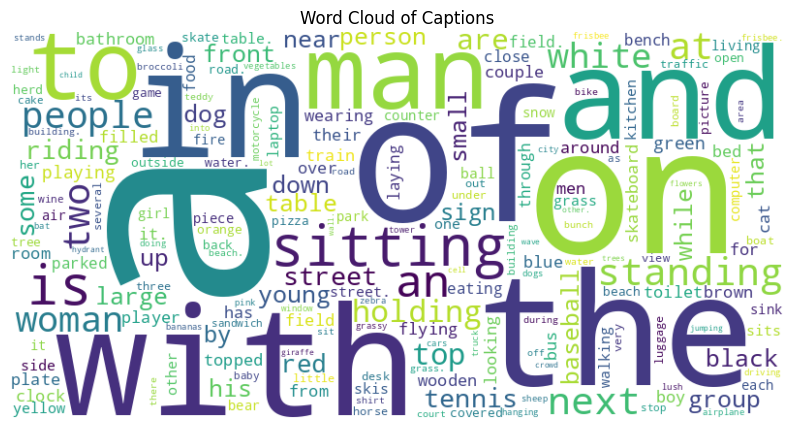

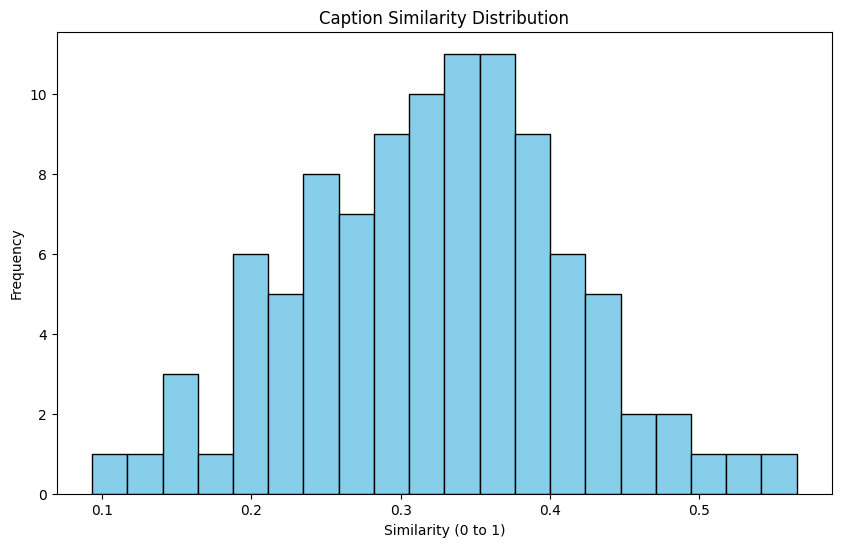

In [ ]:
# @title Visualization
from itertools import combinations
import seaborn as sns
import pandas as pd
from difflib import SequenceMatcher
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def analyze_caption_length(dataset):
    """
    Analyzes the length of captions in the dataset.

    Args:
    - dataset: A COCODataset object containing image-caption pairs.

    Returns:
    - lengths: A list of caption lengths (number of words in each caption).
    """
    lengths = []
    for img_inputs, input_ids, _, _ in dataset:
        if input_ids is not None:
            # Count the number of non-padding tokens in the caption
            caption_length = torch.sum(input_ids != tokenizer.pad_token_id).item()
            lengths.append(caption_length)
    return lengths


from collections import Counter

def analyze_word_frequency(dataset):
    """
    Analyzes the frequency of words in the captions of the dataset.

    Args:
    - dataset: A COCODataset object containing image-caption pairs.

    Returns:
    - word_counter: A Counter object containing word frequencies in the captions.
    """
    word_counter = Counter()
    for _, input_ids, _, _ in dataset:
        if input_ids is not None:
            # Convert input_ids to words using the tokenizer
            words = tokenizer.decode(input_ids, skip_special_tokens=True).lower().split()
            word_counter.update(words)
    return word_counter


# Analyze caption length
caption_lengths = analyze_caption_length(train_loader.dataset)
print(f"Number of captions: {len(caption_lengths)}")
print(f"Average caption length: {sum(caption_lengths)/len(caption_lengths):.2f} words")

# Plot the caption length distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(caption_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Caption Length Distribution')
plt.xlabel('Number of Words in Caption')
plt.ylabel('Frequency')
plt.show()
print()

# Analyze word frequency
word_counter = analyze_word_frequency(train_loader.dataset)
print(f"Total unique words: {len(word_counter)}")
print("Most common words:", word_counter.most_common(10))

# Plot the top 20 most frequent words
most_common_words = word_counter.most_common(20)
if most_common_words:
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts), palette='viridis')
    plt.title('Top 20 Most Frequent Words in Captions')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No words found in the captions.")

print()

def generate_word_cloud(word_counter):
    """
    Generates and displays a word cloud from a Counter object of word frequencies.

    Args:
    - word_counter: A Counter object containing word frequencies.
    """
    # Convert the Counter object to a dictionary for the word cloud
    word_freq_dict = dict(word_counter)

    # Create the word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Captions")
    plt.show()

word_counter = analyze_word_frequency(train_loader.dataset)
generate_word_cloud(word_counter)


# calculate similarity between two captions
def caption_similarity(caption1, caption2):
    """
    Calculate the similarity ratio between two captions using SequenceMatcher.

    Args:
    - caption1: The first caption string.
    - caption2: The second caption string.

    Returns:
    - float: The similarity ratio between 0 and 1.
    """
    return SequenceMatcher(None, caption1, caption2).ratio()

# analyze caption diversity
def analyze_caption_diversity(coco_dataset, num_pairs=100):
    """
    Analyze caption diversity by calculating the similarity between random pairs of captions.

    Args:
    - coco_dataset: The COCO dataset object containing captions.
    - num_pairs: Number of random pairs of captions to compare.

    Returns:
    - List of similarity scores between 0 and 1.
    """
    captions = []

    # Collect all captions from the dataset
    for img_id in coco_dataset.getImgIds():
        ann_ids = coco_dataset.getAnnIds(imgIds=img_id)
        anns = coco_dataset.loadAnns(ann_ids)
        if anns:
            captions.append(anns[0]['caption'])

    # Calculate similarities between random pairs
    similarities = []
    for _ in range(num_pairs):
        caption1, caption2 = random.sample(captions, 2)
        similarity = caption_similarity(caption1, caption2)
        similarities.append(similarity)

    return similarities

print()

# plot caption diversity analysis
def plot_caption_diversity(similarities):
    """
    Plot the histogram of caption similarity scores.

    Args:
    - similarities: List of similarity scores.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(similarities, bins=20, color='skyblue', edgecolor='black')
    plt.title('Caption Similarity Distribution')
    plt.xlabel('Similarity (0 to 1)')
    plt.ylabel('Frequency')
    plt.show()

# Analyze and plot caption diversity
similarities = analyze_caption_diversity(coco_train_captions, num_pairs=100)
plot_caption_diversity(similarities)


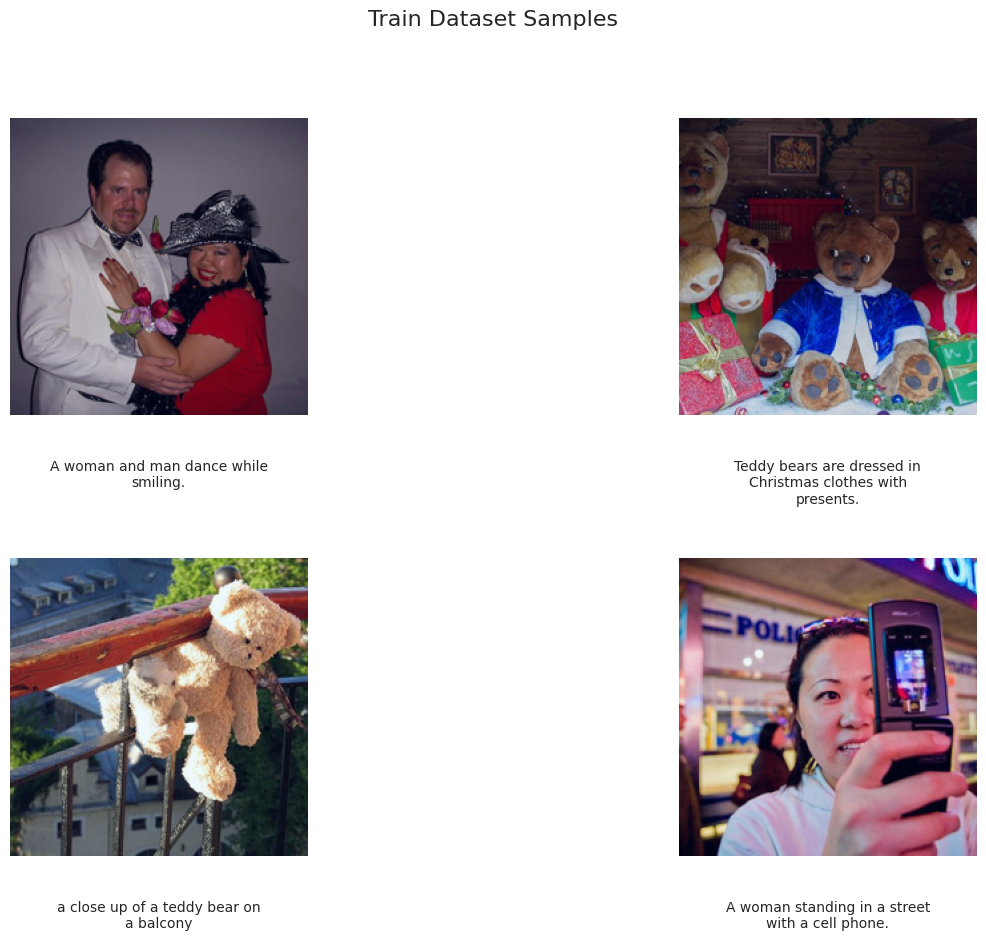

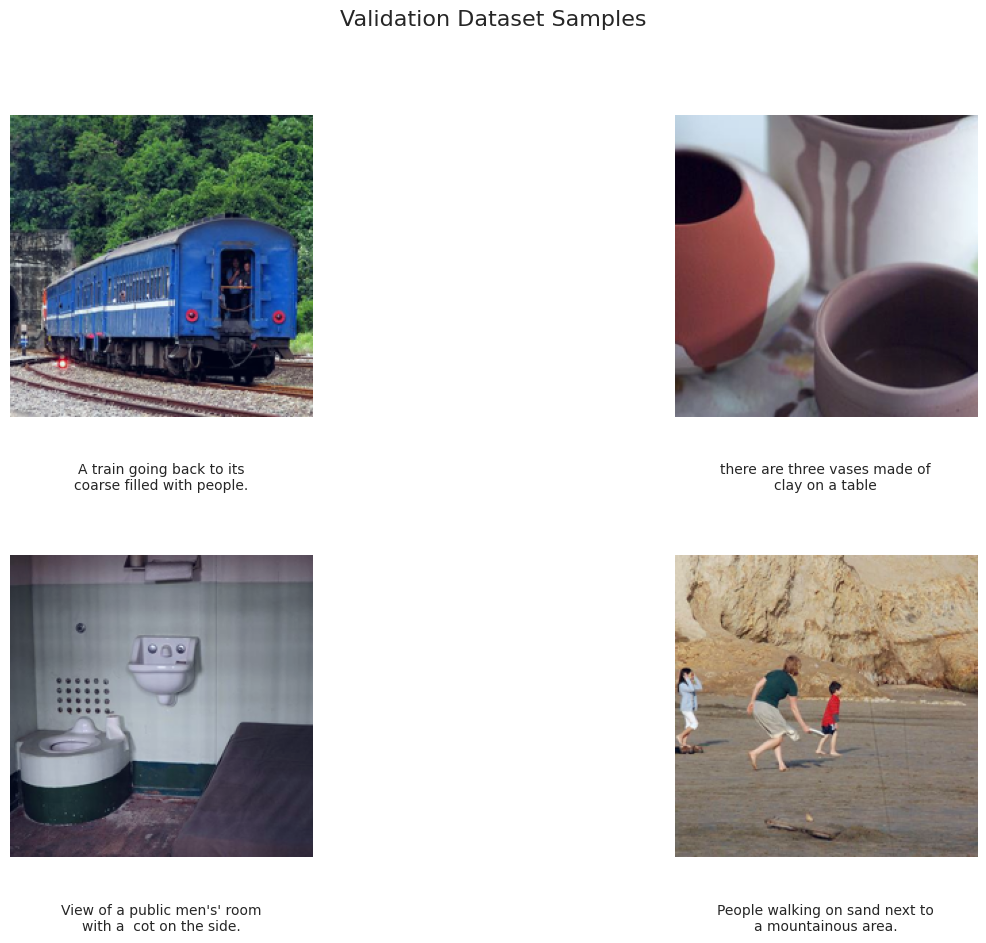

In [ ]:
# @title Display
import numpy as np
import seaborn as sns
from textwrap import wrap

# Rescale the image for proper display
def rescale_image(image_tensor):
    image = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
    return (image * 255).astype(np.uint8)  # Convert to uint8 for proper display

def display_images_with_captions(images, captions, title):
    sns.set_style("white")

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(title, fontsize=16, y=1.0)

    axs = axs.flatten()

    for idx, ax in enumerate(axs):
        if idx < len(images):
            # Rescale and plot the image
            image = rescale_image(images[idx].cpu().numpy().transpose(1, 2, 0))
            ax.imshow(image)
            ax.axis('off')
            caption = "\n".join(wrap(captions[idx], 30))  # Limit line width to 30 characters
            ax.imshow(image)
            ax.axis('off')
            plt.text(0.5, -0.15, caption, fontsize=10, ha='center', va='top', transform=ax.transAxes)
    plt.tight_layout(pad=1.2)
    plt.show()

# Fetch a batch of data from the train_loader and val_loader
def get_images_and_captions_from_loader(loader, num_images=4):
    images, captions, _, objects = next(iter(loader))
    images = images[:num_images]
    captions = captions[:num_images]
    captions_text = [tokenizer.decode(capt, skip_special_tokens=True) for capt in captions]
    return images, captions_text

# Display 4 images from the training dataset
train_images, train_captions = get_images_and_captions_from_loader(train_loader, num_images=4)
display_images_with_captions(train_images, title="Train Dataset Samples", captions=train_captions)
print()
# Display 4 images from the validation dataset
val_images, val_captions = get_images_and_captions_from_loader(val_loader, num_images=4)
display_images_with_captions(val_images, title="Validation Dataset Samples", captions=val_captions)

In [4]:
# @title Mapping model
class EncoderAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, dropout=0.1):
        super(EncoderAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn, _ = self.mha(query=x, value=x, key=x, need_weights=False)
        x = x + attn
        return self.layernorm(x)

# FeedForward class
class FeedForward(nn.Module):
    def __init__(self, embed_dim=768, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim),
            nn.Dropout(dropout_rate)
        )
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.seq(x)
        return self.layernorm(x)

# MapperLayer class (used in TransformerMapper)
class MapperLayer(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, dropout_rate=0.1):
        super(MapperLayer, self).__init__()
        self.attn = EncoderAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout_rate)
        self.ff = FeedForward(embed_dim=embed_dim, dropout_rate=dropout_rate)

    def forward(self, x):
        x = self.attn(x)
        x = self.ff(x)
        return x

#-----------------------------------------------------------------------------------------------------------------------
# Transformer Mapper
class TransformerMapper(nn.Module):
    def __init__(self, dim_clip=512, embed_dim=768, clip_length=16, num_layers=8, num_heads=8, dropout_rate=0.1):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.linear = nn.Linear(dim_clip, embed_dim)  # Map CLIP embedding dimension to GPT-2 embedding dimension
        self.transformer = nn.ModuleList([
            MapperLayer(embed_dim=embed_dim, num_heads=num_heads, dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ])

    def forward(self, clip_embeddings):
        # Project the CLIP embeddings to match GPT-2 embedding dimension
        x = self.linear(clip_embeddings)  # [batch_size, clip_length, embed_dim]
        # Reshape `x` to have 3 dimensions
        for layer in self.transformer:
            x = layer(x)

        return x  # Return embeddings of size [batch_size, clip_length, embed_dim]

#-----------------------------------------------------------------------------------------------------------------------
# Linear mapper
class LinearClipToGptMapper(nn.Module):
    def __init__(self, dim_clip=512, dim_gpt=768):
        """
        A simple linear transformation to map CLIP embeddings to GPT-2 embeddings.
        Args:
            dim_clip: The dimension of CLIP embeddings.
            dim_gpt: The dimension of GPT-2 embeddings.
        """
        super(LinearClipToGptMapper, self).__init__()
        self.linear = nn.Linear(dim_clip, dim_gpt)  # A simple linear layer

    def forward(self, clip_embeddings):
        # Apply the linear transformation
        clip_embeddings_mapped = self.linear(clip_embeddings)
        return clip_embeddings_mapped


# Hugging Face implementation
class ClipToGptModel(nn.Module):
    def __init__(self, clip_model, gpt_model, transformer_mapper):
        super(ClipToGptModel, self).__init__()
        self.clip_model = clip_model  # Pretrained CLIP model
        self.gpt_model = gpt_model  # Pretrained GPT-2 model
        self.transformer_mapper = transformer_mapper  # TransformerMapper to map CLIP embeddings to GPT-2 embeddings

    def forward(self, images, input_ids=None, labels=None):
        # Extract CLIP embeddings from the images
        clip_embedding = self.clip_model.get_image_features(pixel_values=images)  # [batch_size, clip_length, dim_clip]

        # Map CLIP embeddings to GPT-compatible embeddings using transformer_mapper
        clip_embeddings_mapped = self.transformer_mapper(clip_embedding)
        # Handle GPT token embeddings and ensure input length consistency
        max_length = input_ids.size(1)
        token_embeddings = self.gpt_model.transformer.wte(input_ids[:, :max_length])

        # Concatenate CLIP and GPT embeddings
        combined_embeddings = torch.cat((clip_embeddings_mapped.unsqueeze(1), token_embeddings), dim=1)
        # print(f"combined_embeddings shape: {combined_embeddings.shape}")
        # Create attention mask for valid positions
        attention_mask = torch.cat([
            torch.ones(clip_embeddings_mapped.size()[:-1], device=combined_embeddings.device).unsqueeze(1),
            torch.ones(token_embeddings.size()[:-1], device=combined_embeddings.device)
        ], dim=1)
        # print(f"attention_mask shape: {attention_mask.shape}")
                # Adjust labels to match the combined embeddings' sequence length
        if labels is not None:
            # Create a tensor filled with -100 for the CLIP token (to ignore in loss)
            pad_labels = torch.full((labels.size(0), 1), -100, dtype=labels.dtype, device=labels.device)
            # Concatenate the padding to the labels
            padded_labels = torch.cat([pad_labels, labels], dim=1)  # [batch_size, sequence_length + 1]
            # print(f'padded_labels shape: {padded_labels.shape}')
        else:
            padded_labels = None
        # print(f'labels shape:{labels.shape}')
        # print(f'GPT 2 Config: {self.gpt_model.config}')
        # Forward pass through GPT-2
        try:
            outputs = self.gpt_model(
                input_ids = None,
                inputs_embeds=combined_embeddings,
                attention_mask=attention_mask,
                labels=padded_labels
            )
            # print(f"outputs shape: {outputs.logits.shape}")
        except Exception as e:
            print(f"Error during GPT forward pass: {e}")
            raise
        # If labels are provided, calculate loss
        # if labels is not None:
        #     logits = outputs.logits
        #     # Make sure logits and labels have matching dimensions
        #     logits = logits[:, :max_length, :]  # Ensure logits match the length of input_ids
        #     labels = labels[:, :max_length]     # Trim labels to match

        #     # Calculate the loss
        #     loss_fct = torch.nn.CrossEntropyLoss()
        #     loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        #     outputs.loss = loss

        return outputs


# Initialize the model
# transformer_mapper = TransformerMapper(
#     dim_clip=512,        # CLIP model embedding dimension
#     embed_dim=768,       # GPT-2 embedding dimension
#     clip_length=16       # The sequence length of CLIP embeddings (16)
# )
transformer_mapper = LinearClipToGptMapper(dim_clip=512, dim_gpt=768)
model = ClipToGptModel(clip_model, gpt_model, transformer_mapper).to(device)

In [5]:
# @title Training
# Initialize models and processors
import wandb
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

wandb.login(key='3ead90558e07c18e20ea792864d30be4ac4bf6ce')
# Set the environment variable to offline
# os.environ["WANDB_MODE"] = "offline"
# os.environ["WANDB_DISABLED"] = "true"
# Initialize W&B
config = {
    "epochs": 5,
    "batch_size": 8,
    "learning_rate": 5e-4,
    "optimizer": "AdamW"
}
wandb.init(project='clip-gpt-training', entity='zedneroki-ml')
wandb.config.update(config)

# path to save the model in Google Drive
save_path = "/content/drive/MyDrive/clip_gpt_caption_model.pth"

#-----------------------------------------------------------------------------------------------------------------------
def generate_caption(image_tensor, model, transformer_mapper, tokenizer, max_length=50, temperature=0.7):
    model.eval()

    try:
        # Get CLIP image embeddings and map to GPT space
        with torch.no_grad():
            clip_embedding = model.clip_model.get_image_features(pixel_values=image_tensor.to(device).unsqueeze(0))
            print(f"clip_embedding shape: {clip_embedding.shape}")
            mapped_embedding = transformer_mapper(clip_embedding).unsqueeze(1)
            print(f"mapped_embedding shape: {mapped_embedding.shape}")
        # Generate an attention mask (1 for all tokens since no padding is needed in embeddings)
        attention_mask = torch.ones(mapped_embedding.size()[:-1], device=device)

        # Generate caption using GPT-2's generate() method
        generated_ids = model.gpt_model.generate(
            inputs_embeds=mapped_embedding,
            attention_mask=attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_k=70,
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True
        )

        # Decode generated token IDs to text
        # print(f"generated_ids shape: {generated_ids.shape}")
        caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        # print(f"Generated Caption: {caption}")
        return caption

    except Exception as e:
        print(f"Error generating caption: {e}")
        return "Error in generating caption"

def calculate_metrics(generated_captions, reference_captions):
    """
    Calculate BLEU, CIDEr, and SPICE metrics using pycocoevalcap.
    """
    # Prepare the data for COCOEvalCap directly from captions
    gts = {idx: [ref] for idx, ref in enumerate(reference_captions)}  # ground truth (reference captions)
    res = {idx: [gen] for idx, gen in enumerate(generated_captions)}  # generated captions

    # Initialize metric scorers
    bleu_scorer = Bleu(4)
    cider_scorer = Cider()
    spice_scorer = Spice()

    # Compute BLEU scores
    bleu_scores, _ = bleu_scorer.compute_score(gts, res)

    # Compute CIDEr score
    cider_score, _ = cider_scorer.compute_score(gts, res)

    # Compute SPICE score
    spice_score, _ = spice_scorer.compute_score(gts, res)

    return bleu_scores, cider_score, spice_score

def validate(model, val_loader, criterion):
    """
    Validation loop with CIDEr, BLEU, SPICE, and loss evaluation.
    """
    model.eval()
    total_loss = 0
    generated_captions = []
    reference_captions = []

    print("Starting validation...")

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validating")
        for batch_idx, batch in enumerate(progress_bar):
            print(f"Processing batch {batch_idx}...")
            images, input_ids, labels, _ = batch
            images, input_ids, labels = images.to(device), input_ids.to(device), labels.to(device)

            # print(f"input_ids shape: {input_ids.shape}")
            # print(f"labels shape: {labels.shape}")

            # Forward pass and compute loss
            try:
                outputs = model(images, input_ids, labels=labels)  # Forward pass
                logits = outputs.logits[:, :-1, :]
                # print(f"outputs.logits shape: {outputs.logits.shape}")
                loss = criterion(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))  # Compute loss
            except Exception as e:
                print(f"Error during forward pass or loss computation: {e}")
                continue

            total_loss += loss.item()

            # Generate captions for the batch
            try:
                for i, img in enumerate(images):
                    generated_caption = generate_caption(img, model, transformer_mapper, tokenizer)
                    generated_captions.append(generated_caption)

                    # Convert `labels` to ground truth captions
                    reference_caption = tokenizer.decode(labels[i], skip_special_tokens=True)
                    reference_captions.append(reference_caption)
                    print(f"Generated Caption: {generated_caption}")
                    print(f"Reference Caption: {reference_caption}")
            except Exception as e:
                print(f"Error during caption generation: {e}")
                continue

            # Update progress bar with the loss for the current batch
            progress_bar.set_postfix(loss=loss.item())

    # Calculate average loss
    avg_loss = total_loss / len(val_loader)
    print(f"Validation Average Loss: {avg_loss:.4f}")

    # Calculate BLEU, CIDEr, and SPICE using pycocoevalcap
    try:
        print("Calculating metrics...")
        bleu_scores, cider_score, spice_score = calculate_metrics(generated_captions, reference_captions)
        metrics = {
            'bleu': bleu_scores,
            'cider': cider_score,
            'spice': spice_score
        }
        print("Successfully calculated metrics.")
    except Exception as e:
        print(f"Error during metrics calculation: {e}")
        metrics = None

    return avg_loss, metrics


def train(model, data_loader, val_loader, optimizer, criterion, scheduler, epochs=3, save_path=save_path):
    scaler = GradScaler()  # Initialize gradient scaler for mixed precision

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (images, input_ids, labels, _) in enumerate(data_loader):
            images, labels, input_ids = images.to(device), labels.to(device), input_ids.to(device)
            optimizer.zero_grad()
            clip_embedding = model.clip_model.get_image_features(pixel_values=images)
            clip_embedding1 = clip_embedding[0].unsqueeze(1)
            clip_embedding2 = clip_embedding[1].unsqueeze(1)

            cosine_similarity = torch.nn.CosineSimilarity(dim=1)
            sim_score = cosine_similarity(clip_embedding1, clip_embedding2)
            # Take the mean of the similarity scores to get a single value
            mean_sim_score = sim_score.mean()

            # print(f"Overall similarity score between two images: {mean_sim_score.item()}")

            # Forward pass with no autocast
            # Forward pass
            outputs = model(images, input_ids, labels)
            loss = outputs.loss

            # Backpropagation
            loss.backward()

            # Update weights
            optimizer.step()
            # # Forward pass with mixed precision
            # with autocast(device_type='cuda'):
            #     # print(f"images shape: {images.shape}")
            #     # print(f"input_ids shape: {input_ids.shape}")
            #     # print(f"labels shape: {labels.shape}")
            #     outputs = model(images, input_ids, labels)
            #     loss = outputs.loss

            #     # Backpropagation with gradient scaling
            #     scaler.scale(loss).backward()

            #     # Step the optimizer and update the scaler
            #     scaler.step(optimizer)
            #     scaler.update()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}, Loss: {loss.item()}")
                wandb.log({"batch_loss": loss.item()})
                wandb.log({"learning_rate": optimizer.param_groups[0]['lr']})

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())
            progress_bar.update()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")
        wandb.log({"epoch_train_loss": avg_loss})

        # Run validation step after each epoch
        avg_val_loss, metrics = validate(model, val_loader, criterion)
        print(f'avg val loss: {avg_val_loss}')
        # Log validation loss and metrics to Weights & Biases

        wandb.log({
            "epoch_val_loss": avg_val_loss,
            "BLEU-1": metrics['bleu'][0],
            "BLEU-2": metrics['bleu'][1],
            "BLEU-3": metrics['bleu'][2],
            "BLEU-4": metrics['bleu'][3],
            "CIDEr": metrics['cider'],
            "SPICE": metrics['spice']
        })

        # Update the learning rate scheduler
        scheduler.step(avg_loss)

        # Save the model after each epoch
        print(f"Before Saving model to {save_path}")
        torch.save(model.state_dict(), save_path)
        print(f"Model saved after epoch {epoch+1} to {save_path}")

#-----------------
# Initialize optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Initialize learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zedneroki (zedneroki-ml). Use `wandb login --relogin` to force relogin


In [9]:
# Call the train function with all required arguments
train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=3, save_path=save_path)

Epoch 1/3:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.8027995228767395
Batch 10, Loss: 0.7564914226531982
Batch 20, Loss: 0.8750014305114746
Batch 30, Loss: 0.8153123259544373
Batch 40, Loss: 0.7961136102676392
Batch 50, Loss: 0.7816287875175476
Batch 60, Loss: 0.9749767184257507
Epoch [1/3], Average Loss: 0.8764
Starting validation...


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Processing batch 0...
input_ids shape: torch.Size([16, 50])
labels shape: torch.Size([16, 50])
outputs.logits shape: torch.Size([16, 51, 50257])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.Size([1, 14])
Generated Caption: a person sitting on top of a chair drinking a glass of wine
Generated Caption: a person sitting on top of a chair drinking a glass of wine
Reference Caption: a person sitting at a desk with a keyboard and monitor 
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.Size([1, 11])
Generated Caption: A very large white kitchen with furniture and appliances.
Generated Caption: A very large white kitchen with furniture and appliances.
Reference Caption: A political candidate advertisement on the side of a coach bus.
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.Siz

Epoch 2/3:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.6835237741470337
Batch 10, Loss: 0.73805832862854
Batch 20, Loss: 0.5601806640625
Batch 30, Loss: 0.6860439777374268
Batch 40, Loss: 0.5660935044288635
Batch 50, Loss: 0.6210646629333496
Batch 60, Loss: 0.6146015524864197
Epoch [2/3], Average Loss: 0.6144
Starting validation...


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Processing batch 0...
input_ids shape: torch.Size([16, 50])
labels shape: torch.Size([16, 50])
outputs.logits shape: torch.Size([16, 51, 50257])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.Size([1, 17])
Generated Caption: A man and woman are on a couch with a computer keyboard and a phone.
Generated Caption: A man and woman are on a couch with a computer keyboard and a phone.
Reference Caption: a person sitting at a desk with a keyboard and monitor 
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.Size([1, 11])
Generated Caption: A small dog sitting on top of a chair.
Generated Caption: A small dog sitting on top of a chair.
Reference Caption: A political candidate advertisement on the side of a coach bus.
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.Size([1, 13])
Generated

Epoch 3/3:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.4200359582901001
Batch 10, Loss: 0.4045828878879547
Batch 20, Loss: 0.4347257912158966
Batch 30, Loss: 0.4655013680458069
Batch 40, Loss: 0.5327998399734497
Batch 50, Loss: 0.5431882739067078
Batch 60, Loss: 0.6004331111907959
Epoch [3/3], Average Loss: 0.4712
Starting validation...


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Processing batch 0...
input_ids shape: torch.Size([16, 50])
labels shape: torch.Size([16, 50])
outputs.logits shape: torch.Size([16, 51, 50257])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.Size([1, 11])
Generated Caption: A couple of scissors sitting next to each other.
Generated Caption: A couple of scissors sitting next to each other.
Reference Caption: a person sitting at a desk with a keyboard and monitor 
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.Size([1, 16])
Generated Caption: A parking lot filled with lots of yellow flowers next to each other. 
Generated Caption: A parking lot filled with lots of yellow flowers next to each other. 
Reference Caption: A political candidate advertisement on the side of a coach bus.
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
generated_ids shape: torch.S

In [6]:
# @title Inference
import traceback
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def load_model_weights(model, weight_path):
    """
    Load the trained model weights from a file.

    Args:
        model (nn.Module): The model architecture.
        weight_path (str): The path to the saved model weights.

    Returns:
        nn.Module: The model with loaded weights.
    """
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    return model

def sample_from_logits(logits, temperature=0.2, top_k=50):
    """
    Sample the next token from the logits using temperature and top-k sampling.
    Args:
        logits: The logits from the model output (shape: [batch_size, vocab_size]).
        temperature: The temperature to use for sampling.
        top_k: Number of top logits to consider during sampling.
    Returns:
        The index of the next token.
    """
    # Check for NaN or invalid logits
    if torch.isnan(logits).any():
        raise ValueError("Logits contain NaN values")

    # Apply temperature scaling
    logits = logits / temperature

    # Apply top-k sampling (only keep top-k logits)
    top_k_logits, top_k_indices = torch.topk(logits, top_k, dim=-1)
    print(f"Top-k logits shape: {top_k_logits.shape}, Top-k indices shape: {top_k_indices.shape}")

    # Convert logits to probabilities
    probabilities = torch.softmax(top_k_logits, dim=-1)

    # Sample from top-k probabilities
    sampled_token_in_top_k = torch.multinomial(probabilities, num_samples=1)
    print(f"Sampled token (in top-k space): {sampled_token_in_top_k.item()}")

    # Map the sampled token back to the original vocabulary using top_k_indices
    next_token = top_k_indices.gather(-1, sampled_token_in_top_k)
    print(f"Next token index (in original vocab): {next_token.item()}")

    # Ensure the sampled token is within the valid range of the vocabulary
    vocab_size = logits.size(-1)  # Get vocab size from logits
    if next_token.item() >= vocab_size or next_token.item() < 0:
        raise ValueError(f"Sampled token index {next_token.item()} is out of bounds for vocab size {vocab_size}")

    return next_token


# Get CLIP image embeddings
def get_image_tensor(image):
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        clip_embedding = model.clip_model.get_image_features(pixel_values=inputs.pixel_values)

    return clip_embedding

def check_forward_pass(image, input_ids):
    # Preprocess image
    inputs = clip_processor(images=image, return_tensors="pt").to(device)

    # Get CLIP image embeddings
    with torch.no_grad():
        clip_embedding = model.clip_model.get_image_features(pixel_values=inputs.pixel_values)

    # Ensure that the CLIP embeddings are properly reshaped to be fed into GPT-2
    clip_embedding = clip_embedding.unsqueeze(1)

    # Forward pass through the model
    output = model(inputs_embeds=clip_embedding, input_ids=input_ids)
    logits = output.logits

    return logits



# -------------------------------------------------------------------------

# Gradio function to display the debug information
def gradio_caption(image):
    try:
        # Call the caption generation function with the necessary arguments
        image_tensor = clip_processor(images=image, return_tensors="pt").pixel_values.squeeze(0)
        result = generate_caption(image_tensor, model, transformer_mapper, tokenizer)
        return result
    except Exception as e:
        # Capture and print the error traceback
        error_message = traceback.format_exc()
        return f"Error occurred: {str(e)}"

# Initialize Gradio interface
iface = gr.Interface(fn=gradio_caption,
                     inputs=gr.Image(type="pil"),
                     outputs="text",
                     title="CLIP-GPT Image Captioning")

# Launch the interface
iface.launch(debug=False)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5f89cfa5ec8fe4e321.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **BLIP-2: Image Captioning**

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import os
from pycocotools.coco import COCO
import random

# Set device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BLIP-1 processor and model
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Check special tokens in the tokenizer
print("Special tokens in the tokenizer:")
print(f"PAD: {processor.tokenizer.pad_token_id}")
print(f"UNK: {processor.tokenizer.unk_token_id}")
print(f"SEP: {processor.tokenizer.sep_token_id}")
print(f"CLS: {processor.tokenizer.cls_token_id}")

# File paths
TRAIN_IMAGES_DIR = os.path.join(COCO_DIR, 'images', 'train2017')
VAL_IMAGES_DIR = os.path.join(COCO_DIR, 'images', 'val2017')
TRAIN_ANNOTATIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'captions_train2017.json')
VAL_ANNOTATIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'captions_val2017.json')

# Load COCO captions
coco_train = COCO(TRAIN_ANNOTATIONS_FILE)
coco_val = COCO(VAL_ANNOTATIONS_FILE)

# Get list of downloaded image file names
def get_downloaded_image_ids(images_dir):
    return {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')}

# Get image IDs
train_image_ids = get_downloaded_image_ids(TRAIN_IMAGES_DIR)
val_image_ids = get_downloaded_image_ids(VAL_IMAGES_DIR)


# Custom dataset for BLIP-1
class BLIP1CustomDataset(Dataset):
    def __init__(self, coco, images_dir, processor, available_image_ids):
        self.coco = coco
        self.images_dir = images_dir
        self.processor = processor
        self.image_ids = [img_id for img_id in coco.getImgIds() if str(img_id).zfill(12) in available_image_ids]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_filename = os.path.join(self.images_dir, img_info['file_name'])

        try:
            # Load image and check for validity
            image = Image.open(img_filename).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_filename}: {e}")
            return None  # Skip the invalid image

        # Get caption
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        caption = anns[0]['caption'] if anns else ""

        if not caption:
            print(f"Missing or empty caption for image {img_filename}")
            return None  # Skip the image if caption is missing

        # Process the image and caption
        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding="max_length")

        # Remove batch dimension and return
        pixel_values = inputs['pixel_values'].squeeze(0)
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask,
                'img_id': img_id}

# Initialize DataLoader
def initialize_dataloaders(train_image_ids, val_image_ids, batch_size=32, num_workers=4):
    train_dataset = BLIP1CustomDataset(coco_train, TRAIN_IMAGES_DIR, processor, train_image_ids)
    val_dataset = BLIP1CustomDataset(coco_val, VAL_IMAGES_DIR, processor, val_image_ids)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Initialize data loaders
train_loader, val_loader = initialize_dataloaders(train_image_ids, val_image_ids)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Special tokens in the tokenizer:
PAD: 0
UNK: 100
SEP: 102
CLS: 101
loading annotations into memory...


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Done (t=1.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Number of training batches: 301
Number of validation batches: 29


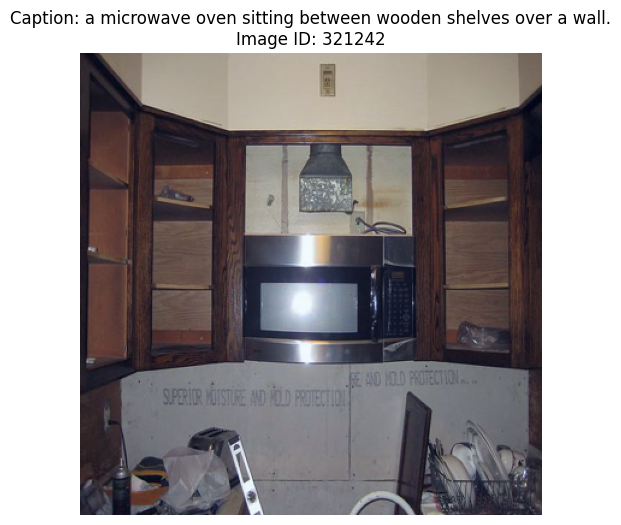

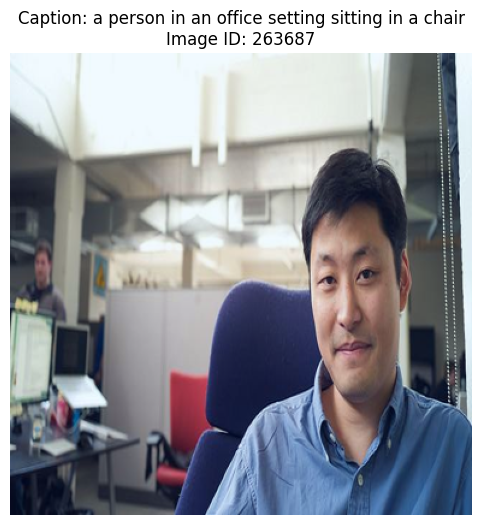

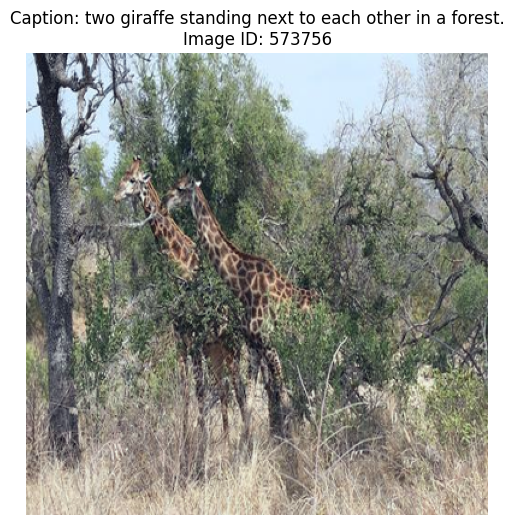

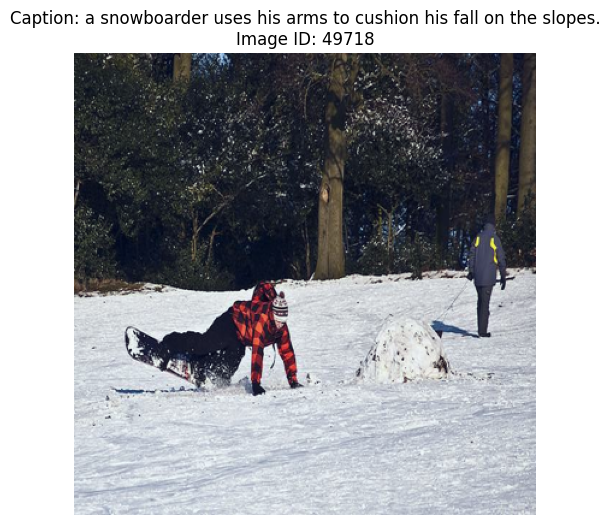

In [ ]:
# @title Visualization
import matplotlib.pyplot as plt

# Function to display images with their captions
def visualize_samples(data_loader, num_samples=4):
    """
    Display a few samples from the data loader with their captions.

    Args:
    - data_loader: DataLoader object to fetch samples from.
    - num_samples: Number of samples to display.
    """
    # Get a batch from the data loader
    batch = next(iter(data_loader))
    images = batch['pixel_values']
    captions = batch['input_ids']
    img_ids = batch['img_id']

    # Check if there are enough samples to display
    if num_samples > len(images):
        num_samples = len(images)

    # Display the samples
    for i in range(num_samples):
        # Convert the image tensor to a PIL image for visualization
        image = images[i].permute(1, 2, 0).cpu().numpy()
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

        # Decode the caption
        caption = processor.decode(captions[i], skip_special_tokens=True)

        # Display the image and its caption
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Caption: {caption}\nImage ID: {img_ids[i]}")
        plt.show()

# Visualize a few samples from the training dataset
visualize_samples(train_loader, num_samples=4)


In [11]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler
import torch.nn as nn
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
import wandb

wandb.login(key='3ead90558e07c18e20ea792864d30be4ac4bf6ce')
wandb.init(project='blip-image-captioning', entity='zedneroki-ml')

config = {
    "epochs": 3,
    "batch_size": 2,
    "learning_rate": 5e-5,
    "optimizer": "AdamW"
}
wandb.config.update(config)

blip_weights_path = "/content/drive/MyDrive/blip_caption_model.pth"

# Initialize optimizer and loss function
def initialize_optimizer_and_scheduler(model, lr=5e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    return optimizer, scheduler

def is_valid_tensor(tensor):
    return not (torch.isnan(tensor).any() or torch.isinf(tensor).any())

# Fine-tuning function with gradient accumulation, mixed precision, and memory optimizations
def fine_tune_blip(model, train_loader, val_loader, optimizer, scheduler, epochs=3):
    # scaler = GradScaler(init_scale=1024)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            optimizer.zero_grad()
            # Validate inputs
            if not is_valid_tensor(pixel_values) or not is_valid_tensor(input_ids):
                print("Invalid input detected.")
                continue

            outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask,
                            labels=input_ids)
            # Check the shape of the logits and input_ids
            # print(f"Logits shape: {outputs.logits.shape}")
            # print(f"Input IDs shape: {input_ids.shape}")
            loss = outputs.loss
            # Check for NaN loss early to avoid further computation
            if torch.isnan(loss):
                print("NaN loss detected. Stopping training.")
                break
            loss.backward()
            # Check gradient norms
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f"Gradient norm for {name}: {param.grad.norm()}")
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # prevent exploding gradients
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        # Calculate average training loss for the epoch
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} completed with average train loss: {avg_train_loss:.4f}")

        # Validate and adjust learning rate
        total_val_loss = validate_blip(model, val_loader)
        scheduler.step(total_val_loss)

        # Call evaluate_model to compute captioning metrics
        print(f"Evaluating captions for Epoch {epoch+1}/{epochs}...")
        metrics = evaluate_model(model, processor, val_loader, coco_val)
        print(f"Metrics for Epoch {epoch+1}: {metrics}")

        # Log metrics and losses to wandb
        try:
            wandb.log({
                "train_loss": avg_train_loss,
                "val_loss": total_val_loss,
                "BLEU-1": metrics.get('BLEU-1', 0),
                "BLEU-2": metrics.get('BLEU-2', 0),
                "BLEU-3": metrics.get('BLEU-3', 0),
                "BLEU-4": metrics.get('BLEU-4', 0),
                "CIDEr": metrics.get('CIDEr', 0),
                "SPICE": metrics.get('SPICE', 0),
                "epoch": epoch + 1
            })
            print("Metrics logged to wandb successfully.")
        except Exception as e:
            print(f"Failed to log metrics to wandb: {e}")

        # Save model checkpoint
        torch.save(model.state_dict(), blip_weights_path)
        print(f"Model saved to {blip_weights_path}")

# Validation loop
def validate_blip(model, val_loader):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask,
                            labels=input_ids)
            # Check the shape of the logits and input_ids
            # print(f"Logits shape: {outputs.logits.shape}")
            # print(f"Input IDs shape: {input_ids.shape}")
            loss = outputs.loss

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Validation loss: {avg_val_loss:.4f}")
    model.train()
    return avg_val_loss

def compute_metrics(gts, res):
    """
    Computes BLEU, CIDEr, and SPICE scores for generated captions.

    Args:
    - gts: Dictionary of ground truth captions, where keys are image IDs and values are lists of captions.
    - res: Dictionary of generated captions, where keys are image IDs and values are lists of captions.

    Returns:
    - metrics: Dictionary containing the computed BLEU, CIDEr, and SPICE scores.
    """
    # Initialize the scorers
    bleu_scorer = Bleu(4)
    cider_scorer = Cider()
    spice_scorer = Spice()

    # Compute BLEU scores
    bleu_score, _ = bleu_scorer.compute_score(gts, res)
    # Compute CIDEr score
    cider_score, _ = cider_scorer.compute_score(gts, res)
    # Compute SPICE score
    spice_score, _ = spice_scorer.compute_score(gts, res)

    # Store the results in a dictionary
    metrics = {
        'BLEU-1': bleu_score[0],
        'BLEU-2': bleu_score[1],
        'BLEU-3': bleu_score[2],
        'BLEU-4': bleu_score[3],
        'CIDEr': cider_score,
        'SPICE': spice_score
    }

    return metrics

def evaluate_model(model, processor, val_loader, coco_val):
    """
    Evaluates the model on the validation dataset by generating captions and computing metrics.

    Args:
    - model: The image captioning model.
    - processor: Processor for pre-processing images and decoding captions.
    - val_loader: DataLoader for validation data.
    - coco_val: COCO object for accessing ground truth captions.

    Returns:
    - metrics: Dictionary of computed BLEU, CIDEr, and SPICE scores.
    """
    gts = {}  # Ground truth captions
    res = {}  # Generated captions

    # Set model to evaluation mode
    model.eval()

    # Generate captions for the entire validation set
    for batch in val_loader:
        pixel_values = batch['pixel_values'].to(device)
        img_ids = batch['img_id']  # Get image IDs from the batch
        # Print shapes for debugging
        print(f"Pixel Values Shape: {pixel_values.shape}")
        print(f"Image IDs: {img_ids}")

        with torch.no_grad():
            generated_ids = model.generate(pixel_values=pixel_values, max_length=30)
            generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)
            # print(f"Generated token IDs: {generated_ids}")
            # print(f"Generated captions: {generated_captions}")

        # For each image in the batch, retrieve its reference caption and generated caption
        for i, img_id in enumerate(img_ids):
            # Load reference captions using img_id
            img_id = img_id.item() if isinstance(img_id, torch.Tensor) else img_id
            ann_ids = coco_val.getAnnIds(imgIds=img_id)
            anns = coco_val.loadAnns(ann_ids)
            gts[img_id] = [ann['caption'] for ann in anns]  # Ground truth captions

            # Print ground truth and generated captions for debugging
            print(f"Ground truth captions for image {img_id}: {gts[img_id]}")
            print(f"Generated caption for image {img_id}: {generated_captions[i]}")

            # Store the generated caption for the image
            res[img_id] = [generated_captions[i]]  # Generated captions

    # Compute metrics (BLEU, CIDEr, SPICE)
    metrics = compute_metrics(gts, res)

    print("Evaluation Results:")
    for metric_name, score in metrics.items():
        print(f"{metric_name}: {score:.4f}")

    return metrics

# Caption generation
def generate_caption(model, processor, image):
    if image is None:
        return 'Error: No image provided'

    print(f"Received image: {type(image)}")
    image = image.convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    print(f"Pixel values range: {inputs['pixel_values'].min().item()} to {inputs['pixel_values'].max().item()}")

    with torch.no_grad():
        generated_ids = model.generate(
        pixel_values=inputs['pixel_values'],
        max_length=30)
        print(f"Generated token IDs: {generated_ids}")
        caption = processor.decode(generated_ids[0], skip_special_tokens=True)

    return caption

# Load COCO captions
coco_train_captions = COCO(TRAIN_ANNOTATIONS_FILE)
coco_val_captions = COCO(VAL_ANNOTATIONS_FILE)

# Initialize dataloaders
train_loader, val_loader = initialize_dataloaders(
    list(train_image_ids)[:100],
    list(val_image_ids)[:10],
    batch_size=2
)

# Initialize optimizer and scheduler
optimizer, scheduler = initialize_optimizer_and_scheduler(model, lr=5e-5)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [12]:
# Fine-tune the model
fine_tune_blip(model, train_loader, val_loader, optimizer, scheduler, epochs=2)





Epoch 1/2:   0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1/2:   0%|          | 0/50 [00:01<?, ?it/s, loss=13]



Epoch 1/2:   2%|▏         | 1/50 [00:01<01:03,  1.29s/it, loss=13]



Epoch 1/2:   2%|▏         | 1/50 [00:02<01:03,  1.29s/it, loss=10.6]



Epoch 1/2:   4%|▍         | 2/50 [00:02<01:00,  1.26s/it, loss=10.6]



Epoch 1/2:   4%|▍         | 2/50 [00:03<01:00,  1.26s/it, loss=9.53]



Epoch 1/2:   6%|▌         | 3/50 [00:03<00:55,  1.19s/it, loss=9.53]



Epoch 1/2:   6%|▌         | 3/50 [00:04<00:55,  1.19s/it, loss=9.04]



Epoch 1/2:   8%|▊         | 4/50 [00:04<00:52,  1.15s/it, loss=9.04]



Epoch 1/2:   8%|▊         | 4/50 [00:05<00:52,  1.15s/it, loss=8.71]



Epoch 1/2:  10%|█         | 5/50 [00:05<00:51,  1.13s/it, loss=8.71]



Epoch 1/2:  10%|█         | 5/50 [00:07<00:51,  1.13s/it, loss=8.5] 



Epoch 1/2:  12%|█▏        | 6/50 [00:07<00:51,  1.17s/it, loss=8.5]



Epoch 1/2:  12%|█▏        | 6/50 [00:08<00:51,  1.17s/it, loss=8.31]



Epoch 1/2:  14%|█▍  

Epoch 1/2 completed with average train loss: 6.1028






Validating:   0%|          | 0/5 [00:00<?, ?it/s]



Validating:  20%|██        | 1/5 [00:00<00:03,  1.15it/s]



Validating:  40%|████      | 2/5 [00:01<00:02,  1.29it/s]



Validating:  60%|██████    | 3/5 [00:02<00:01,  1.63it/s]



Validating:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]



Validating: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Validation loss: 2.8166
Evaluating captions for Epoch 1/2...
Pixel Values Shape: torch.Size([2, 3, 384, 384])
Image IDs: tensor([507223,  80666])
Ground truth captions for image 507223: ['A man that is standing in the dirt with a bat.', 'a baseball player is holding a bat on a field', 'A baseball players is ealking toward the opposing team.', 'The player approaches home plate to take his turn at bat.', 'A group of baseball players standing next to each other on top of a field.']
Generated caption for image 507223: a baseball player is standing next to a man on the field
Ground truth captions for image 80666: ['A cat sitting on top of a bench in a field.', 'A cat sitting on a bench in front of a house', 'a close up of a cat sitting on a bench', 'a white and brown cat sitting alone on a bench ', 'A cat sitting on a bench in front of a building.']
Generated caption for image 80666: a cat sitting on a rock next to a fence
Pixel Values Shape: torch.Size([2, 3, 384, 384])
Image IDs: tensor([





Epoch 2/2:   0%|          | 0/50 [00:00<?, ?it/s]



Epoch 2/2:   0%|          | 0/50 [00:00<?, ?it/s, loss=2.8]



Epoch 2/2:   2%|▏         | 1/50 [00:00<00:20,  2.40it/s, loss=2.8]



Epoch 2/2:   2%|▏         | 1/50 [00:00<00:20,  2.40it/s, loss=2.68]



Epoch 2/2:   4%|▍         | 2/50 [00:00<00:19,  2.40it/s, loss=2.68]



Epoch 2/2:   4%|▍         | 2/50 [00:01<00:19,  2.40it/s, loss=2.55]



Epoch 2/2:   6%|▌         | 3/50 [00:01<00:19,  2.39it/s, loss=2.55]



Epoch 2/2:   6%|▌         | 3/50 [00:01<00:19,  2.39it/s, loss=2.5] 



Epoch 2/2:   8%|▊         | 4/50 [00:01<00:19,  2.39it/s, loss=2.5]



Epoch 2/2:   8%|▊         | 4/50 [00:02<00:19,  2.39it/s, loss=2.32]



Epoch 2/2:  10%|█         | 5/50 [00:02<00:18,  2.39it/s, loss=2.32]



Epoch 2/2:  10%|█         | 5/50 [00:02<00:18,  2.39it/s, loss=2.2] 



Epoch 2/2:  12%|█▏        | 6/50 [00:02<00:18,  2.40it/s, loss=2.2]



Epoch 2/2:  12%|█▏        | 6/50 [00:02<00:18,  2.40it/s, loss=2.07]



Epoch 2/2:  14%|█▍ 

Epoch 2/2 completed with average train loss: 0.8583






Validating:   0%|          | 0/5 [00:00<?, ?it/s]



Validating:  20%|██        | 1/5 [00:00<00:00,  7.96it/s]



Validating:  40%|████      | 2/5 [00:00<00:00,  7.85it/s]



Validating:  60%|██████    | 3/5 [00:00<00:00,  7.87it/s]



Validating:  80%|████████  | 4/5 [00:00<00:00,  7.89it/s]



Validating: 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Validation loss: 0.0866
Evaluating captions for Epoch 2/2...
Pixel Values Shape: torch.Size([2, 3, 384, 384])
Image IDs: tensor([507223,  80666])
Ground truth captions for image 507223: ['A man that is standing in the dirt with a bat.', 'a baseball player is holding a bat on a field', 'A baseball players is ealking toward the opposing team.', 'The player approaches home plate to take his turn at bat.', 'A group of baseball players standing next to each other on top of a field.']
Generated caption for image 507223: a baseball player is standing on the field
Ground truth captions for image 80666: ['A cat sitting on top of a bench in a field.', 'A cat sitting on a bench in front of a house', 'a close up of a cat sitting on a bench', 'a white and brown cat sitting alone on a bench ', 'A cat sitting on a bench in front of a building.']
Generated caption for image 80666: a white cat is sitting outside of a building
Pixel Values Shape: torch.Size([2, 3, 384, 384])
Image IDs: tensor([ 75456, 2

In [13]:
for batch in train_loader:
    print("Pixel Values Shape:", batch['pixel_values'].shape)
    print("Input IDs Shape:", batch['input_ids'].shape)
    print("Attention Mask Shape:", batch['attention_mask'].shape)
    # Print the actual captions
    decoded_captions = processor.batch_decode(batch['input_ids'], skip_special_tokens=True)
    print("Sample Captions:", decoded_captions[:3])
    break

Pixel Values Shape: torch.Size([2, 3, 384, 384])
Input IDs Shape: torch.Size([2, 512])
Attention Mask Shape: torch.Size([2, 512])
Sample Captions: ['a man that is flying some kind of kite', 'a red blender filled with liquid on a counter.']


In [ ]:
import gradio as gr

# Load fine-tuned model weights
try:
    model.load_state_dict(torch.load(blip_weights_path, map_location=device))
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
model.eval()

def gradio_caption(image):
    try:
        caption = generate_caption(model, processor, image)
        print(f"Generated caption: {caption}")
        return caption
    except Exception as e:
        # Capture and print the error traceback
        error_message = traceback.format_exc()
        return f"Error occurred: {str(e)}"

# Initialize Gradio interface
iface = gr.Interface(fn=gradio_caption,
                     inputs=gr.Image(type="pil"),
                     outputs="text",
                     title="CLIP-GPT Image Captioning")

# Launch the interface
iface.launch(debug=True)

<ipython-input-14-8741a5e0d619>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(blip_weights_path, map_location=device))


Model loaded successfully.
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://329817a2c7484538a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Received image: <class 'PIL.Image.Image'>
Pixel values range: -1.7922625541687012 to 2.1458969116210938
Generated token IDs: tensor([[30522,  1037,  2309,  6847,  1999,  1037,  2380,  2279,  2000,  1037,
          3392,  3561,  2181,  1012,   102]], device='cuda:0')
Generated caption: a single bench in a park next to a tree filled area.
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://329817a2c7484538a9.gradio.live
